In [3]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "cpu"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 

meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_71050/4006151839.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


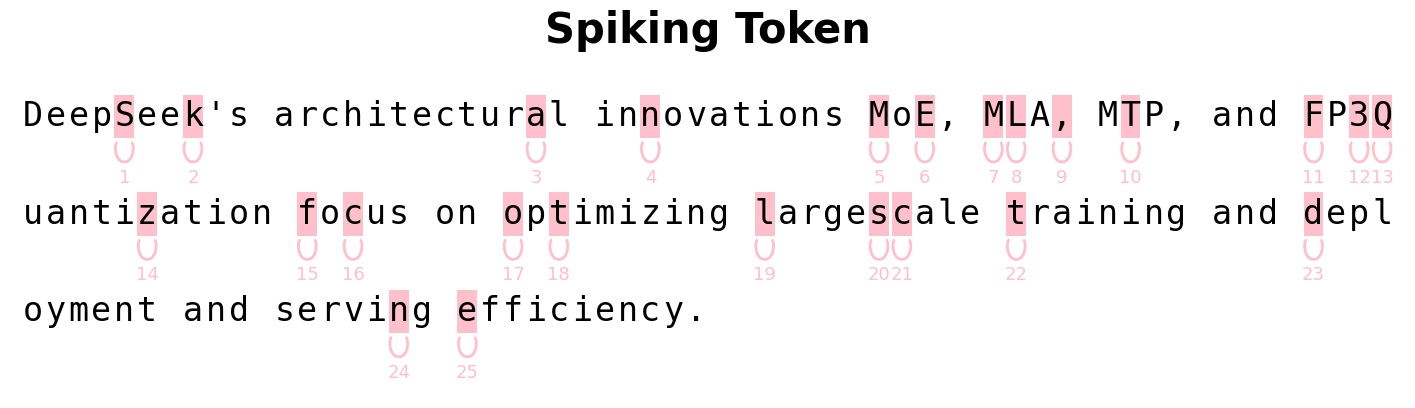

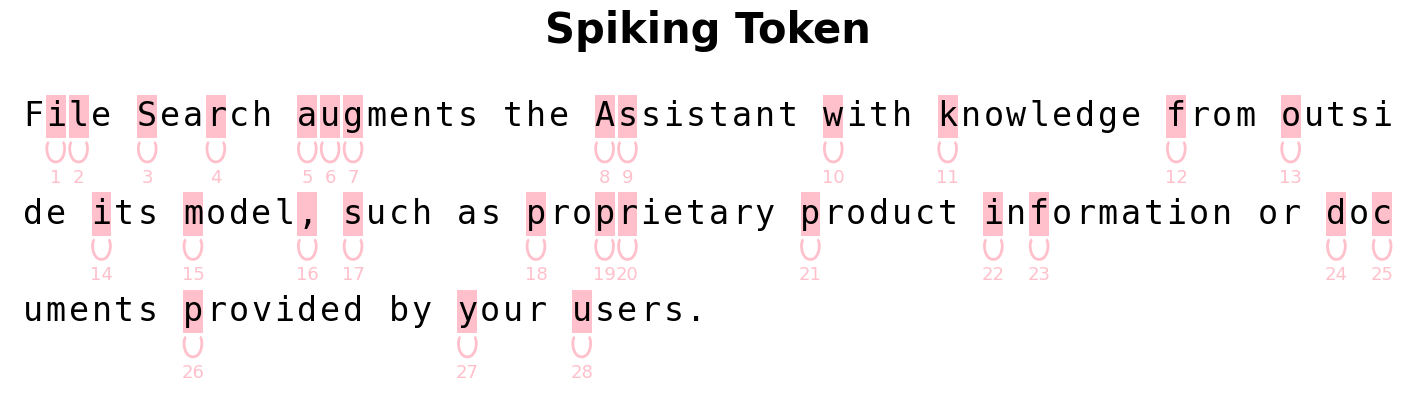

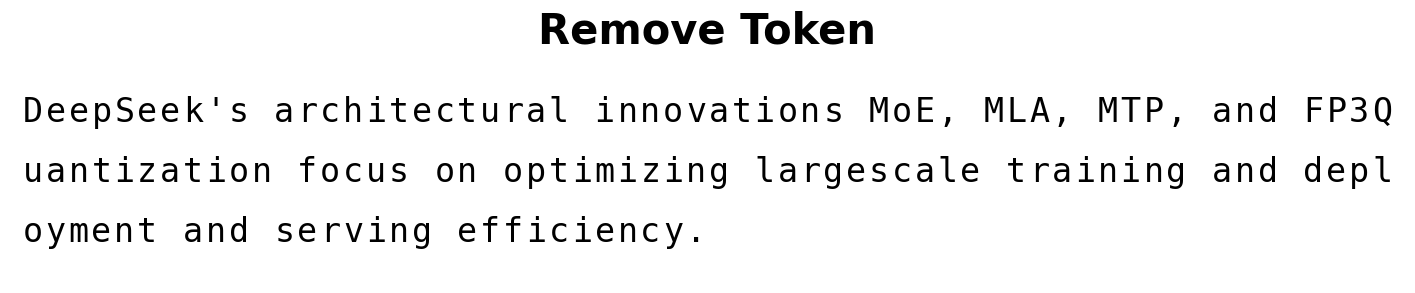

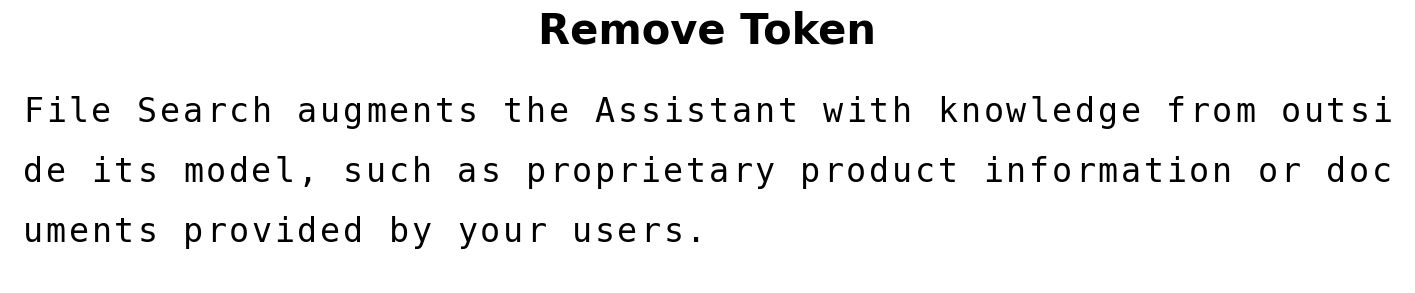

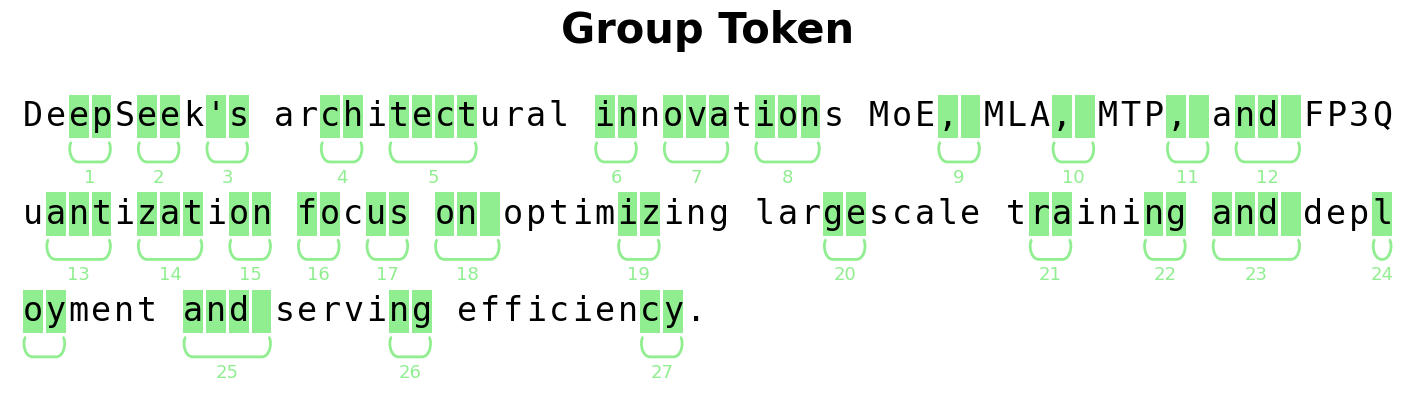

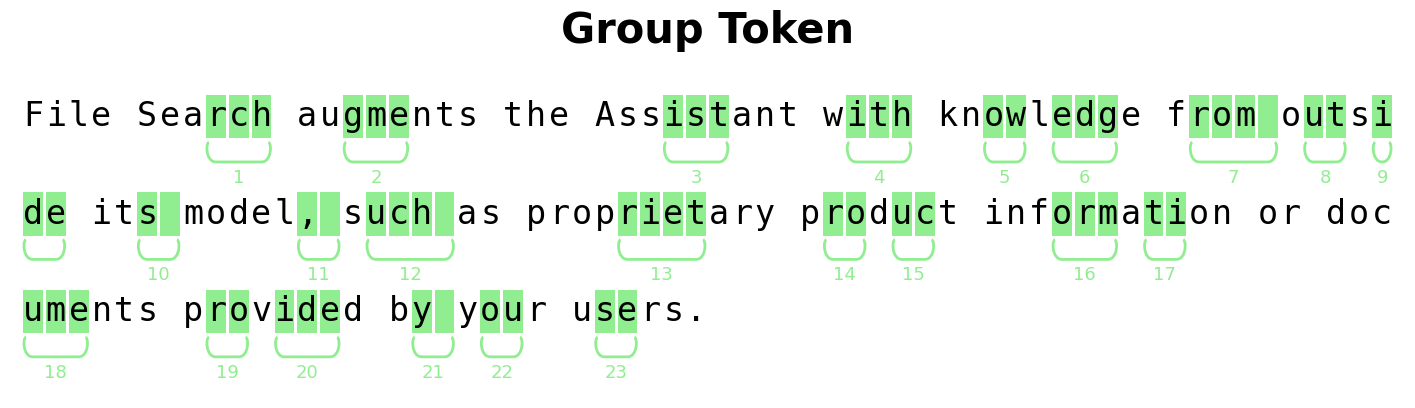

In [4]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base")

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [5]:
# cache vocabulary change 
magicab.cache_vocab_change(texts)

# update vocabulary 
magicab.update_vocab()

 :: Add new token ep  Id: 92
 :: Add new token s   Id: 93
 :: Add new token te  Id: 94
 :: Add new token tec  Id: 95
 :: Add new token tect  Id: 96
 :: Add new token l   Id: 97
 :: Add new token ov  Id: 98
 :: Add new token ova  Id: 99
 :: Add new token ovat  Id: 100
 :: Add new token on  Id: 101
 :: Add new token ,   Id: 102
 :: Add new token nd  Id: 103
 :: Add new token nd   Id: 104
 :: Add new token ti  Id: 105
 :: Add new token tio  Id: 106
 :: Add new token tion  Id: 107
 :: Add new token fo  Id: 108
 :: Add new token us  Id: 109
 :: Add new token on   Id: 110
 :: Add new token in  Id: 111
 :: Add new token ing  Id: 112
 :: Add new token la  Id: 113
 :: Add new token ge  Id: 114
 :: Add new token le  Id: 115
 :: Add new token le   Id: 116
 :: Add new token ra  Id: 117
 :: Add new token lo  Id: 118
 :: Add new token loy  Id: 119
 :: Add new token an  Id: 120
 :: Add new token and  Id: 121
 :: Add new token and   Id: 122
 :: Add new token ng  Id: 123
 :: Add new token cy  Id: 124
 

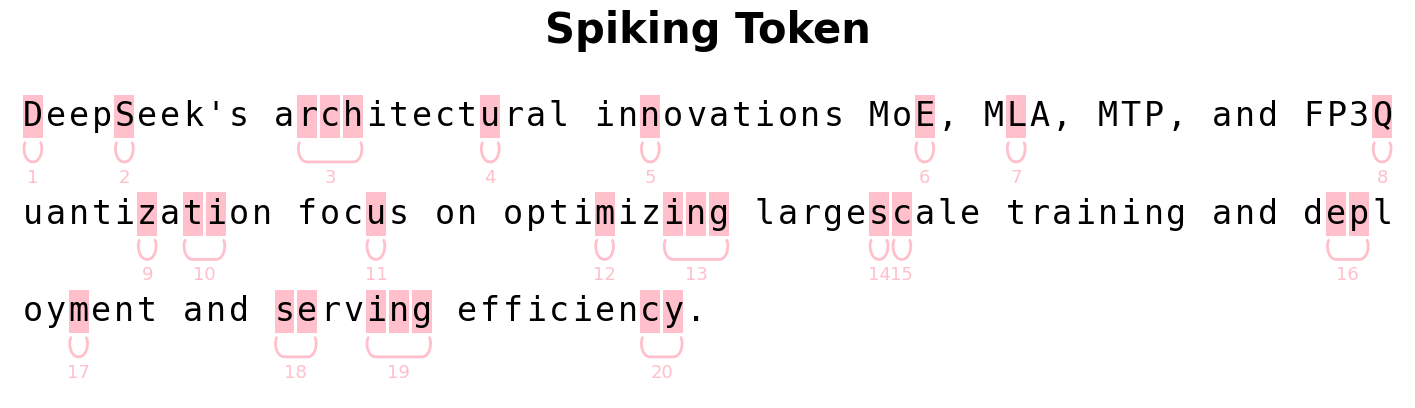

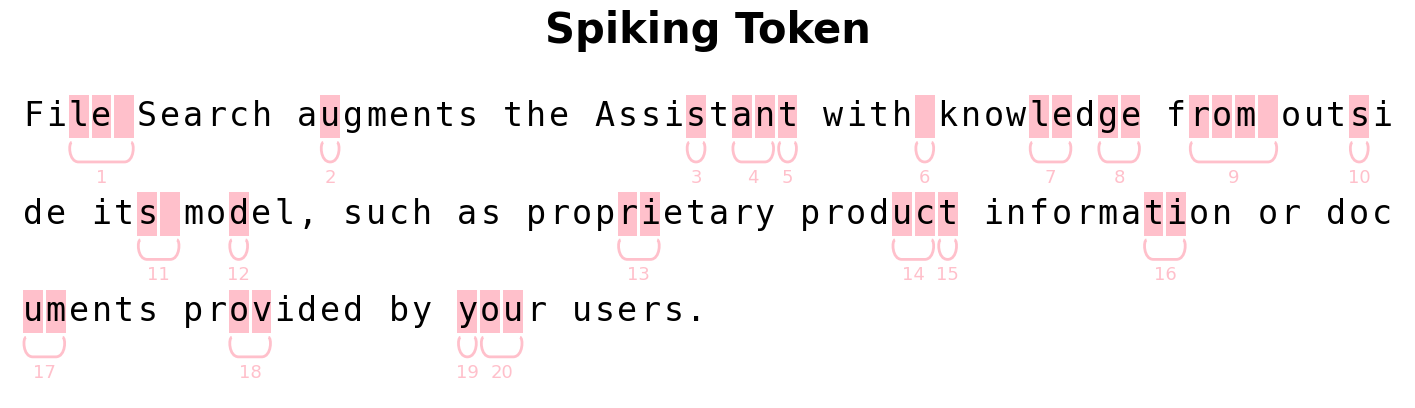

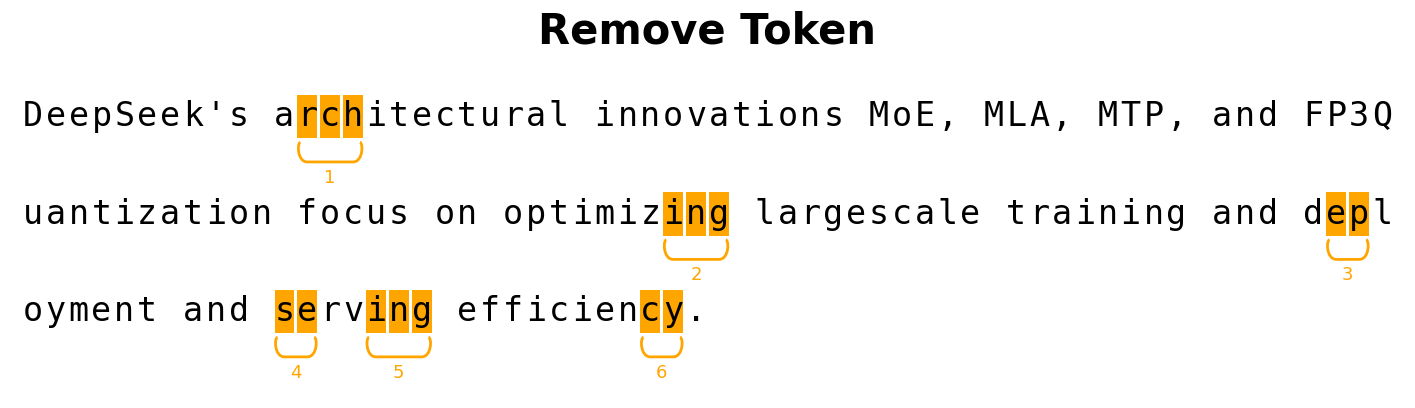

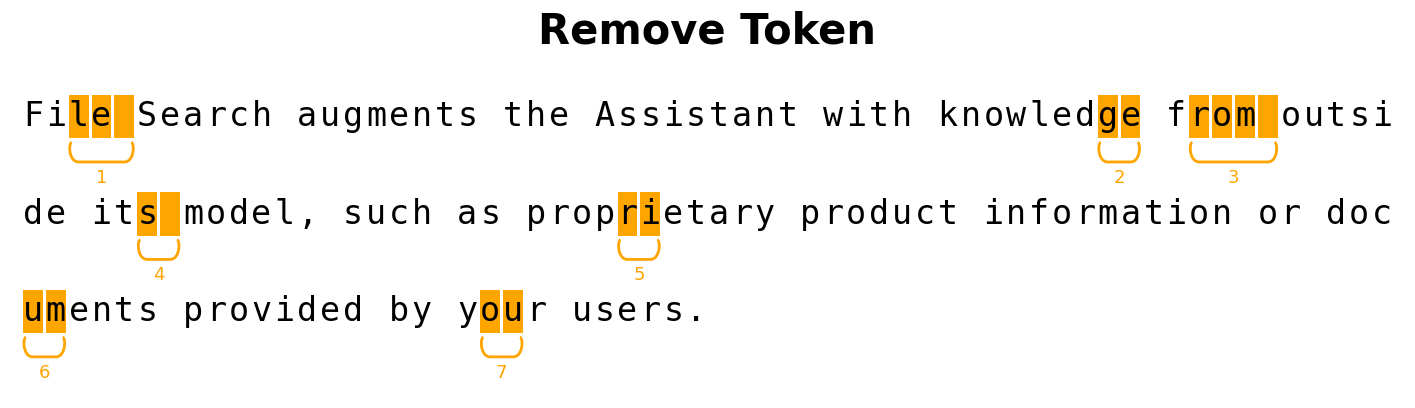

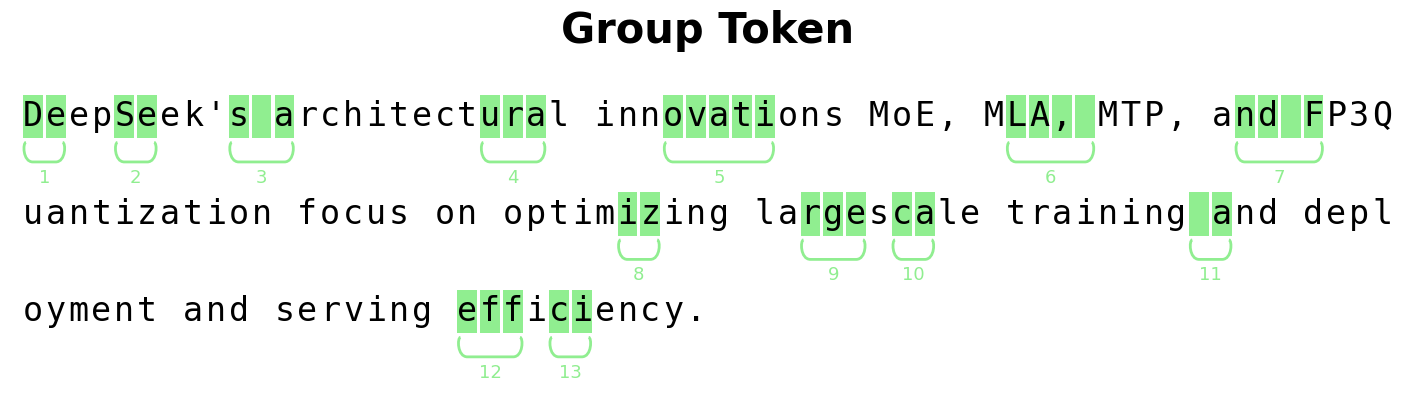

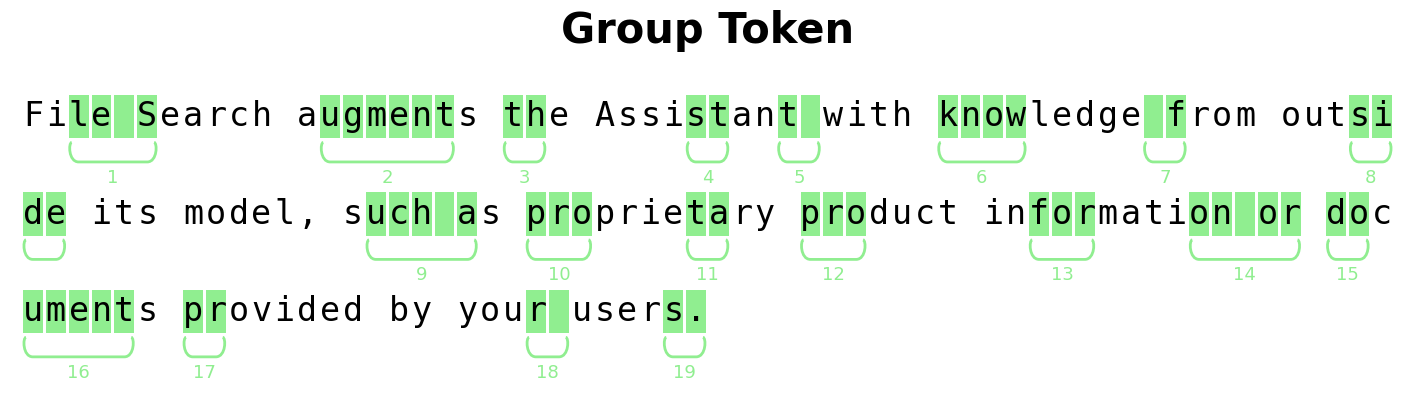

In [6]:
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [7]:
from data.enwiki.util import prepare_enwiki_data

# Update data with tokenizer (11min --> 40s with rust tokenization)
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 


Input file path:  data/enwiki/enwik8_clean.txt
Encoding data with tokenizer ...
Total tokens: 54482072
Vocab size: 156
train has 40,708,558 tokens
val has 1,619,723 tokens
test has 2,022,711 tokens


{'vocab_size': 156,
 'itos': {0: '\n',
  1: ' ',
  2: '!',
  3: '#',
  4: '$',
  5: '%',
  6: "'",
  7: '(',
  8: ')',
  9: '*',
  10: '+',
  11: ',',
  12: '-',
  13: '.',
  14: '/',
  15: '0',
  16: '1',
  17: '2',
  18: '3',
  19: '4',
  20: '5',
  21: '6',
  22: '7',
  23: '8',
  24: '9',
  25: ':',
  26: ';',
  27: '=',
  28: '?',
  29: '@',
  30: 'A',
  31: 'B',
  32: 'C',
  33: 'D',
  34: 'E',
  35: 'F',
  36: 'G',
  37: 'H',
  38: 'I',
  39: 'J',
  40: 'K',
  41: 'L',
  42: 'M',
  43: 'N',
  44: 'O',
  45: 'P',
  46: 'Q',
  47: 'R',
  48: 'S',
  49: 'T',
  50: 'U',
  51: 'V',
  52: 'W',
  53: 'X',
  54: 'Y',
  55: 'Z',
  56: '\\',
  57: '^',
  58: '_',
  59: '`',
  60: 'a',
  61: 'b',
  62: 'c',
  63: 'd',
  64: 'e',
  65: 'f',
  66: 'g',
  67: 'h',
  68: 'i',
  69: 'j',
  70: 'k',
  71: 'l',
  72: 'm',
  73: 'n',
  74: 'o',
  75: 'p',
  76: 'q',
  77: 'r',
  78: 's',
  79: 't',
  80: 'u',
  81: 'v',
  82: 'w',
  83: 'x',
  84: 'y',
  85: 'z',
  86: '{',
  87: '|',
  88: '}',
 

In [ ]:
# (c). Work with training data batch

# magicab need to work with 'batch data'
import numpy as np 
dataset = 'enwiki'
block_size = 256 
batch_size = 4
device_type = 'cuda'

data_dir = os.path.join('data', dataset)

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y